In [8]:
from tensorflow.keras.applications import efficientnet as efn
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random


In [2]:
anns_file_path = 'coco/annotations/instances_val2017.json'
images_dir = 'coco/images/val2017'

In [3]:
# open annotations file
with open(anns_file_path, 'r') as f:
    anns = json.loads(f.read())

In [4]:
# Load the annotations into a DataFrame
anns_df = pd.DataFrame(anns['annotations'])
anns_df.drop_duplicates(subset=['image_id'], inplace=True)
anns_df.head()

,segmentation,area,iscrowd,image_id,bbox,category_id,id
0,"[[510.66, 423.01, 511.72, 420.03, 510.45, 416....",702.10575,0,289343,"[473.07, 395.93, 38.65, 28.67]",18,1768
1,"[[289.74, 443.39, 302.29, 445.32, 308.09, 427....",27718.47630,0,61471,"[272.1, 200.23, 151.97, 279.77]",18,1773
2,"[[147.76, 396.11, 158.48, 355.91, 153.12, 347....",78969.31690,0,472375,"[124.71, 196.18, 372.85, 356.81]",18,2551
3,"[[260.4, 231.26, 215.06, 274.01, 194.33, 307.6...",108316.66515,0,520301,"[112.71, 154.82, 367.29, 479.35]",18,3186
4,"[[200.61, 253.97, 273.19, 318.49, 302.43, 336....",75864.53530,0,579321,"[200.61, 89.65, 400.22, 251.02]",18,3419


In [5]:
len(anns_df)

4952

In [6]:
def add_zeros_and_extension(image_ids):
    # Convert image_ids to strings and add '.jpg' extension
    image_paths = [f'{str(image_id).zfill(12)}.jpg' for image_id in image_ids]
    return image_paths

anns_df['file_name'] = add_zeros_and_extension(anns_df['image_id'])
anns_df.head()

,segmentation,area,iscrowd,image_id,bbox,category_id,id,file_name
0,"[[510.66, 423.01, 511.72, 420.03, 510.45, 416....",702.10575,0,289343,"[473.07, 395.93, 38.65, 28.67]",18,1768,000000289343.jpg
1,"[[289.74, 443.39, 302.29, 445.32, 308.09, 427....",27718.47630,0,61471,"[272.1, 200.23, 151.97, 279.77]",18,1773,000000061471.jpg
2,"[[147.76, 396.11, 158.48, 355.91, 153.12, 347....",78969.31690,0,472375,"[124.71, 196.18, 372.85, 356.81]",18,2551,000000472375.jpg
3,"[[260.4, 231.26, 215.06, 274.01, 194.33, 307.6...",108316.66515,0,520301,"[112.71, 154.82, 367.29, 479.35]",18,3186,000000520301.jpg
4,"[[200.61, 253.97, 273.19, 318.49, 302.43, 336....",75864.53530,0,579321,"[200.61, 89.65, 400.22, 251.02]",18,3419,000000579321.jpg


In [7]:
anns_df['file_name'] = anns_df['file_name'].astype(str)

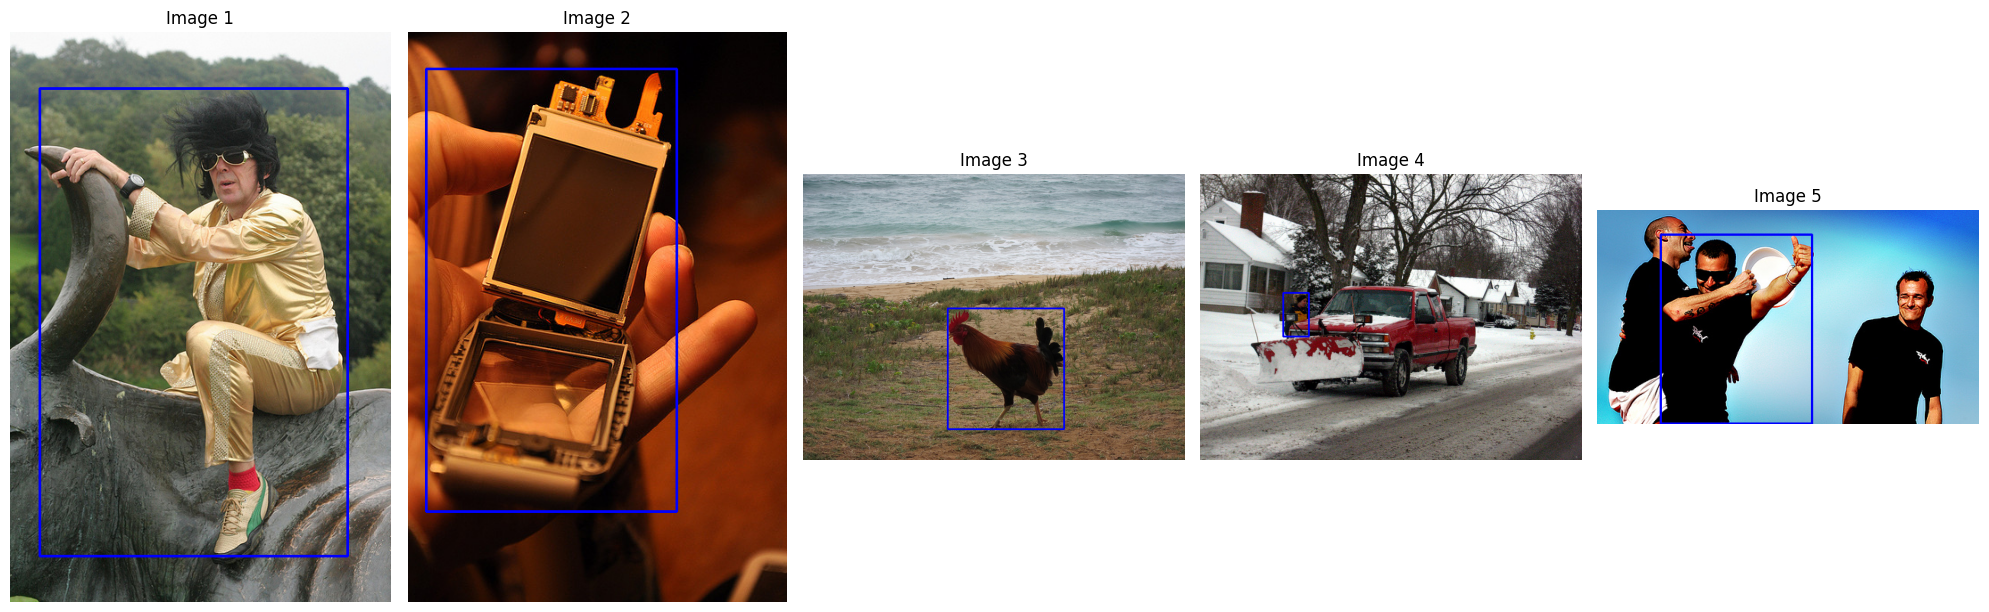

In [9]:
# Define the directory containing images
images_dir = "coco/images/val2017"

# Function to draw bounding boxes and display images
def draw_bounding_boxes(image_ids, anns_df, images_dir, num_images=5):
    # Select 5 random image IDs
    random_image_ids = random.sample(list(image_ids), num_images)
    
    # Create a subplot with 5 rows
    fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(20, 6))

    # Iterate over the selected random image IDs
    for i, image_id in enumerate(random_image_ids):
        # Load the image
        image_path = os.path.join(images_dir, image_id)
        image = cv2.imread(image_path)

        # Get the bounding box coordinates
        bbox = anns_df.loc[anns_df['file_name'] == image_id, 'bbox'].values[0]
        bbox = [int(coord) for coord in bbox]
        x, y, w, h = bbox

        # Draw the bounding box on the image
        image_with_bbox = cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Display the image with bounding box
        axes[i].imshow(cv2.cvtColor(image_with_bbox, cv2.COLOR_BGR2RGB))
        axes[i].axis('off')
        axes[i].set_title(f"Image {i+1}")

    plt.tight_layout()
    plt.show()

# Call the function to draw bounding boxes for 5 random images
draw_bounding_boxes(anns_df['file_name'], anns_df, images_dir, num_images=5)


In [14]:
train_df['file_name'].values

array(['000000296222.jpg', '000000498747.jpg', '000000578093.jpg', ...,
       '000000255747.jpg', '000000497344.jpg', '000000531036.jpg'],
      dtype=object)

In [19]:
# Define the directory path where the images are stored
image_dir = 'coco/images/val2017/'

# Update the DataFrame column with the full image paths
anns_df['file_name'] = image_dir + anns_df['file_name']

In [43]:
print(train_df['category_id'].unique())

[62 44  7 64 70 25  6  1 21  3  5 37 19 85 20 28 15 73 60 11 24 65 17 18
 67 77 16 10 13 22 72 63  4 88 86 32 41  9 59  2 55 54 14 57 81 42 39 36
 82 46 23  8 50 89 49 75 34 87 90 48 51 47 84 43 56 79 61 52 38 35 53 33
 58 78 40 31 74 76 80 27]


In [47]:
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

IMAGE_SIZE = (299, 299)
batch_size = 64
input_shape = (299, 299)

# Convert image paths to strings
anns_df['file_name'] = anns_df['file_name'].astype(str)

# Perform train-test split
train_df, val_df = train_test_split(anns_df, test_size=0.1, random_state=42)

# Convert image paths to strings
train_df['file_name'] = train_df['file_name'].astype(str)
val_df['file_name'] = val_df['file_name'].astype(str)

# Define data generators
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, input_shape[:2])
    image = preprocess_input(image)
    return image, label

# Convert labels to one-hot encoded format
num_classes = 91  # Assuming there are 80 classes in your dataset
train_labels = tf.keras.utils.to_categorical(train_df['category_id'].values, num_classes=num_classes)
val_labels = tf.keras.utils.to_categorical(val_df['category_id'].values, num_classes=num_classes)

# Create TensorFlow Dataset objects with labels
train_ds = tf.data.Dataset.from_tensor_slices((train_df['file_name'].values, train_labels))
train_ds = train_ds.map(preprocess_image).batch(batch_size)

val_ds = tf.data.Dataset.from_tensor_slices((val_df['file_name'].values, val_labels))
val_ds = val_ds.map(preprocess_image).batch(batch_size)


from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.losses import Huber

def get_cnn_model():
    # Load pre-trained EfficientNetB0 model
    base_model = EfficientNetB0(
        input_shape=(299, 299, 3), include_top=False, weights="imagenet")
    
    # Freeze feature extractor layers
    base_model.trainable = False
    
    # Unfreeze the last few layers for fine-tuning
    for layer in base_model.layers[-10:]:
        layer.trainable = True
    
    # Add a global average pooling layer
    x = layers.GlobalAveragePooling2D()(base_model.output)
    
    # Add a dense layer with appropriate units
    x = layers.Dense(128, activation='relu')(x)
    
    # Add the output layer
    # output = layers.Dense(1)(x)

    # Add the output layer with softmax activation for multi-class classification
    output = layers.Dense(num_classes, activation='softmax')(x)

    
    # Define the model
    cnn_model = models.Model(base_model.input, output)
    return cnn_model


# Get the CNN model
cnn_model = get_cnn_model()

# Compile the model with Smooth L1 Loss
cnn_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                  loss=Huber(),
                  metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model on your dataset with early stopping
history = cnn_model.fit(train_ds,
                        epochs=50,
                        validation_data=val_ds)
                        # callbacks=[early_stopping])


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 242s 3s/step - accuracy: 0.0327 - loss: 0.0054 - val_accuracy: 0.1774 - val_loss: 0.0052
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.2137 - loss: 0.0051 - val_accuracy: 0.2500 - val_loss: 0.0051
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 68s 956ms/step - accuracy: 0.2872 - loss: 0.0049 - val_accuracy: 0.3387 - val_loss: 0.0048
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.3632 - loss: 0.0046 - val_accuracy: 0.3891 - val_loss: 0.0043
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.4210 - loss: 0.0041 - val_accuracy: 0.4435 - val_loss: 0.0039
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 72s 986ms/step - accuracy: 0.4704 - loss: 0.0037 - val_accuracy: 0.4577 - val_loss: 0.0038
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 69s 985ms/step - accuracy: 0.5121 - loss: 0.0034 - val_accuracy: 0.4940 - val_loss: 0.0036
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.5483 - loss: 0.0032 - val_accuracy: 0.4919

In [50]:
# Save the model
cnn_model.save('fine_tuned_efficientnet.keras')

In [59]:
import plotly.graph_objects as go

# Create interactive plot for loss
fig_loss = go.Figure()
fig_loss.add_trace(go.Scatter(x=list(range(1, len(history.history['loss']) + 1)), y=history.history['loss'], mode='lines', name='Train'))
fig_loss.add_trace(go.Scatter(x=list(range(1, len(history.history['val_loss']) + 1)), y=history.history['val_loss'], mode='lines', name='Validation'))
fig_loss.update_layout(title='Model Loss Over Epochs', xaxis_title='Epoch', yaxis_title='Loss')
fig_loss.show()

# Create interactive plot for accuracy
fig_accuracy = go.Figure()
fig_accuracy.add_trace(go.Scatter(x=list(range(1, len(history.history['accuracy']) + 1)), y=history.history['accuracy'], mode='lines', name='Train'))
fig_accuracy.add_trace(go.Scatter(x=list(range(1, len(history.history['val_accuracy']) + 1)), y=history.history['val_accuracy'], mode='lines', name='Validation'))
fig_accuracy.update_layout(title='Model Accuracy Over Epochs', xaxis_title='Epoch', yaxis_title='Accuracy')
fig_accuracy.show()


In [56]:
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model

# Load the model
model = tf.keras.models.load_model('fine_tuned_efficientnet.keras')

# Reshape the output of 'top_activation'
reshaped_output = Reshape((-1, 1280))(model.get_layer('top_activation').output)

# Create a new model with the modified architecture
new_model = Model(inputs=model.input, outputs=reshaped_output)

# Verify the modified architecture
# new_model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_14        │ (None, 299, 299,  │          0 │ input_layer_7[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_7     │ (None, 299, 299,  │          7 │ rescaling_14[0][… │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_15        │ (None, 299, 299,  │          0 │ normalization_7[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_15[0][… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 893,232 (3.41 MB)

 Non-trainable params: 3,156,339 (12.04 MB)

In [60]:
# save new model
new_model.save('reshaped_finetuned_model.keras')

# image captioning cnn model summary

In [ ]:
from tensorflow.keras.applications import efficientnet

def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet")
    # Freeze feature extractor layers
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, 1280))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model

# Get the CNN model
summary_cnn_model = get_cnn_model()

In [ ]:
summary_cnn_model.layers[-8:]

In [ ]:
summary_cnn_model.summary()